In [1]:
from SimPEG import  maps, utils
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
import empymod
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import animation, collections

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

import sys
# sys.path.append("..")  # 添加上一级目录到sys.path
# from utils import  simulation # 导入module模块
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('bmh')

/tmp/ipykernel_24330/2301404441.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import  maps, utils


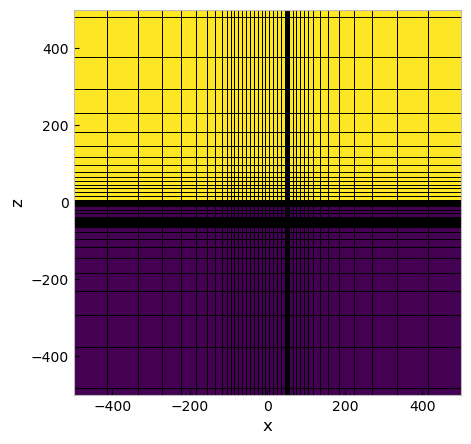

In [6]:
dh = 10.0
hx = [(dh, 20, -1.3),(dh, 15), (1, 10), (dh, 5),(dh, 20, 1.3)]
hy = [(dh, 20, -1.3), (dh, 1), (dh, 20, 1.3)]
# hz = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
hz = [(dh, 20, -1.3),  (1, 15), (0.1, 10), (1, 10), (dh, 3), (1, 15), (dh, 6), (dh, 20, 1.3)]
mesh = TensorMesh([hx, hy, hz], "CCC")

halfspace_value = 100.0

# Find cells below topography and define mapping
air_value = 1e8
ind_active = mesh.gridCC[:, 2] < 0.0
model_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model
model = halfspace_value * np.ones(ind_active.sum())

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.shape_cells[1] / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title("Model slice at y = {} m".format(mesh.cell_centers_y[ind_slice]))
ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])
ax.set_title("")
ax.grid(False)

plt.show()

In [4]:
mesh

TensorMesh: 284,130 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     70     -8,297.15      8,297.15      1.00  1,900.50   10.00
   y     41     -8,197.15      8,197.15     10.00  1,900.50    1.30
   z     99     -8,257.65      8,257.65      0.10  1,900.50   13.00

In [5]:
def get_mesh():
    dh = 10.0
    hx = [(dh, 20, -1.3),(dh, 15), (1, 10), (dh, 5),(dh, 20, 1.3)]
    hy = [(dh, 20, -1.3), (dh, 1), (dh, 20, 1.3)]
    # hz = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    # hz = [(dh, 20, -1.3),  (1, 15), (0.1, 10), (1, 15),(dh, 10), (dh, 20, 1.3)]
    hz = [(dh, 20, -1.3),  (1, 15), (0.1, 10), (1, 10), (dh, 3), (1, 15), (dh, 6), (dh, 20, 1.3)]
    # hz = [(dh, 20, -1.3),  (1, 10), (0.1, 10), (1, 10), (dh, 3), (1, 10), (dh, 6), (dh, 20, 1.3)]
    mesh = TensorMesh([hx, hy, hz], "CCC")
    return mesh

def set_layer_model(mesh):
    sigma_air = 1e-8
    sigma_layer1 = 1/100
    sigma_layer2 = 1/100
    sigma_layer3 = 1/100
    sigma_layer4 = 1/100
    sigma_layer5 = 1/100

    model = np.ones(mesh.nC) * sigma_air
    layer1 = ((mesh.gridCC[:,2] > -10) & (mesh.gridCC[:,2] <= 0))
    layer2 = ((mesh.gridCC[:,2] > -50) & (mesh.gridCC[:,2] <= -10))
    layer3 = ((mesh.gridCC[:,2] > -50.5) & (mesh.gridCC[:,2] <= -49.5))
    layer4 = ((mesh.gridCC[:,2] > -90) & (mesh.gridCC[:,2] <= -50.5))
    layer5 = ((mesh.gridCC[:,2] <= -90))

    model[layer1] = sigma_layer1
    model[layer2] = sigma_layer2
    model[layer3] = sigma_layer3
    model[layer4] = sigma_layer4
    model[layer5] = sigma_layer5
    return model

def plot_model(mesh, model, title=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ind_slice = int(mesh.shape_cells[1] / 2)
    mesh.plot_slice(np.log10(model), normal="Y", ax=ax, ind=ind_slice, grid=True)
    ax.set_xlim([-100, 100])
    ax.set_ylim([-4, 2])


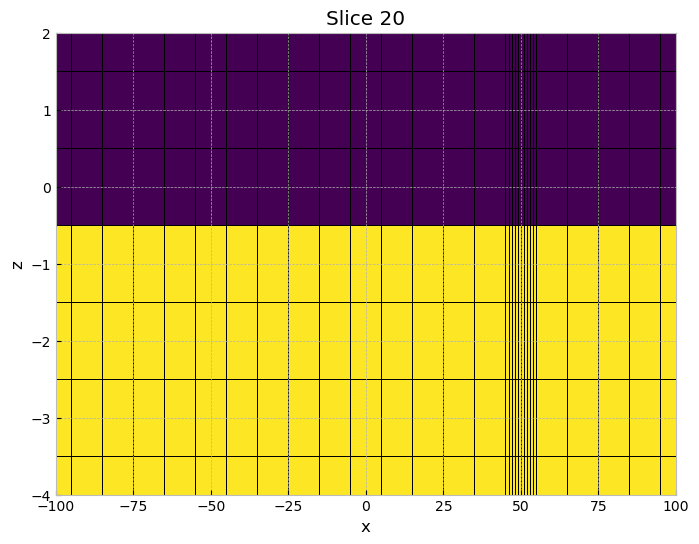

In [6]:
mesh = get_mesh()
model = set_layer_model(mesh)
plot_model(mesh, model, title="Layered Model")

In [7]:
mesh

TensorMesh: 284,130 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     70     -8,297.15      8,297.15      1.00  1,900.50   10.00
   y     41     -8,197.15      8,197.15     10.00  1,900.50    1.30
   z     99     -8,257.65      8,257.65      0.10  1,900.50   13.00

In [8]:
def forward(mesh, model, source_locations, receiver_locations, path):
    times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)

    # src_list = []
    rec_list = []
    # Set up the receiver list
    # for i in ["x"]:
    #     rec_list.append(tdem.Rx.PointElectricField(
    #             orientation=i,
    #             times=self.times,
    #             locations=self.receiver_locations,
    #         ))
    for i in ["x", "y", "z"]:
        rec_list.append(tdem.Rx.PointElectricField(
                orientation=i,
                times=times,
                locations=receiver_locations,
            ))
    # for i in ["x", "y", "z"]:
    #     rec_list.append(tdem.Rx.PointMagneticFluxTimeDerivative(
    #                 orientation = i,
    #                 times=times,
    #                 locations=receiver_locations)
    #                 )
    # Set up the source list
    src_list = [
        tdem.Src.LineCurrent(
            receiver_list=rec_list,
            location=np.array(source_locations),
        ),
    ]


    # Create `Survey`
    survey = tdem.Survey(src_list)

    # time_steps = [1e-1, (1e-2, 21), (3e-2, 23), (1e-1, 21), (3e-1, 23)]
    time_steps =  [1e-7, (1e-7,81), (3e-7,81), (1e-6,81), (3e-6,81), (1e-5, 81), (3e-5, 81),(1e-4, 81), (3e-4, 81),(1e-3, 81),(3e-3, 61)]
    # time_steps =  [1e-7, (1e-7,21), (3e-7,21), (1e-6,21), (3e-6,21), (1e-5, 21), (3e-5, 21),(1e-4, 21), (3e-4, 21),(1e-3, 21)]
    # Define the `Simulation`
    prob = tdem.Simulation3DElectricField(
        mesh,
        survey=survey,
        sigmaMap=maps.IdentityMap(mesh),
        solver=Solver,
        time_steps=time_steps,
        verbose = True
    )

    # Run the forward simulation
    # prob.mu = self.mur*mu_0
    dpred = prob.dpred(model)
    np.save(path, dpred)

In [9]:
mesh

TensorMesh: 284,130 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     70     -8,297.15      8,297.15      1.00  1,900.50   10.00
   y     41     -8,197.15      8,197.15     10.00  1,900.50    1.30
   z     99     -8,257.65      8,257.65      0.10  1,900.50   13.00

In [10]:
receiver_locations = np.array([[50, 0, -1.5]])
source_locations = np.array([[-60, 0, -1.5], [-50, 0, -1.5]])

path = "./data2/3D_solution_halfspace.npy"
mesh = get_mesh()
model = set_layer_model(mesh)
forward(mesh, model, source_locations, receiver_locations, path)

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

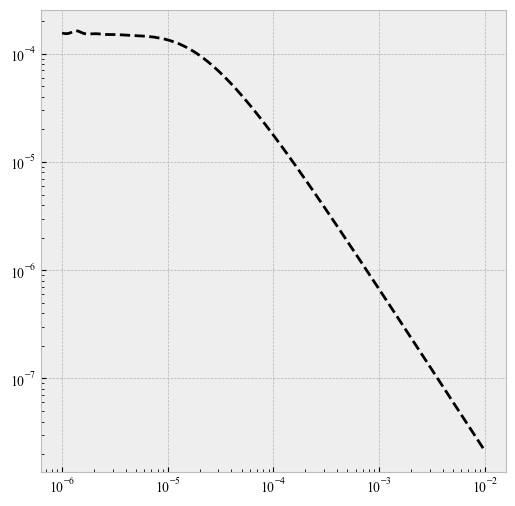

In [19]:
# Source: 100 m x-directed diplole at the origin,
# 50 m above seafloor, src [x1, x2, y1, y2, z1, z2]

src = [-60, -50, 0, 0, -1, -1]

# Receiver: x-directed dipole at 2 km on the
# seafloor, rec = [x, y, z, azimuth, dip]
rec = [50, 0, -1, 0, 0]

# Times to compute, 0.1 - 10 s, 301 steps
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)

inp = {
    "src": src.copy(),
    "rec": rec.copy(),
    "depth": [0, -9.5, -49.5, -50.5, -90.5],
    # "res": [1e4,res_sea, res_bg],
    "res": [1e8, 100, 100, 100, 100, 100],
    "freqtime": times,
    "signal": -1,  # Switch-off
    "srcpts": 300,  # 5 points for finite length approx
    "strength": 1.02,  # Account for source length
    "verb": 1,
}

inp2 = {
    "src": src.copy(),
    "rec": rec.copy(),
    "depth": [0, -9.5, -49.5, -49.6, -90.5],
    # "res": [1e4,res_sea, res_bg],
    "res": [1e8, 10, 100, 1e-6, 100, 300],
    "freqtime": times,
    "signal": -1,  # Switch-off
    "srcpts": 500,  # 5 points for finite length approx
    "strength": 1.02,  # Account for source length
    "verb": 1,
}

inp3 = {
    "src": src.copy(),
    "rec": rec.copy(),
    "depth": [0, -9.5, -49.5, -49.6, -90.5],
    # "res": [1e4,res_sea, res_bg],
    "res": [1e8, 10, 100, 1e-6, 100, 100],
    "freqtime": times,
    "signal": -1,  # Switch-off
    "srcpts": 100,  # 5 points for finite length approx
    "strength": 1.02,  # Account for source length
    "verb": 1,
}

epm_bg = empymod.bipole(**inp)
# epm_bg2 = empymod.bipole(**inp2)
# epm_bg3 = empymod.bipole(**inp3)

fig= plt.subplots(figsize=(6, 6))

plt.rcParams["font.family"] = "Times New Roman"

ax1 = plt.subplot(111)
ax1.loglog(times, np.abs(epm_bg), "k--")
# ax1.loglog(times, np.abs(epm_bg2), "C0-")
# ax1.loglog(times, np.abs(epm_bg3), "C1--")

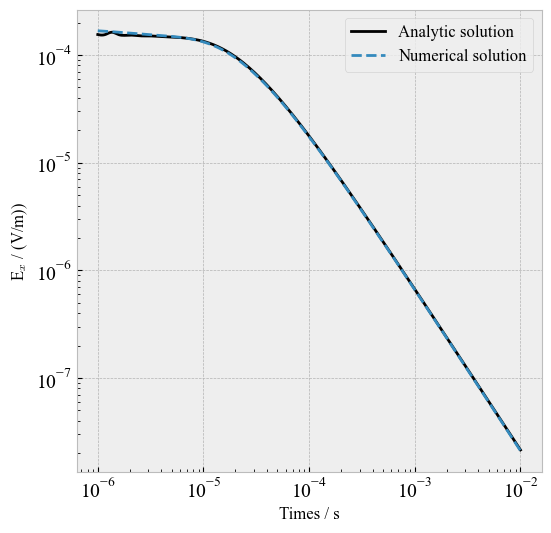

In [20]:
dobs = np.load("./data2/3D_solution_halfspace.npy").reshape((3,300))
# dana = np.load("./data/analytic_solution.npy")

fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams["font.family"] = "Times New Roman"

ax.loglog(times, np.abs(epm_bg), "k-")
ax.loglog(times, np.abs(dobs[0]), "C0--")

ax.set_xlabel("Times / s")
ax.set_ylabel("E$_x$ / (V/m))")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(["Analytic solution", "Numerical solution"], loc = 1, fontsize = 12)
plt.savefig("./Halfspace_new.png", dpi=350, bbox_inches='tight')